# Calculate NEDI with Penman approach

In [65]:
# load input data of daily flux and lai
workdir = 'D:/Field/NATT/modeling_et_afm_v16b/' # this maybe need change according where you place the directory of modeling_et
edata <- read.csv(file= paste0(workdir, 'data/allsite6_flux_NEDI.csv'),head=T)

In [66]:
# Function calculating potential ET with PT approach
F_PET_PT <- function (driver)  
  {  
  # driver: rn, rg, ta
  day_length = driver$day_length   # number of hours in a whole day
  rg  = driver$rg          # ground heat flux, W/m2    
  rn  = driver$rn          # net radiation, W/m2
  ta  = driver$ta          # air temperature    
  ## slope of the relationship between saturated vapor pressure and temperature
  delta   = 17.081 * 234.175 * (6.1078 * exp(17.081 * ta / (ta + 234.175))) / (ta + 234.175)^2 / 10 ## unit kPA / K
  epsilon = delta/gamma
  ETp  = epsilon * (rn - rg) / (epsilon + 1)  # unit W/m2 
  scale_day  = day_length * 3600 / 2.45 * 10^-6 # transform to unit mm/d
  ETp = 1.26 * ETp * scale_day }

In [37]:
# Function calculating potential ET (Penman approach, Shuttleworth 1993)
F_PET_PM <- function (driver)  
  {  
  # driver: rn, rg, ta
  day_length = driver$day_length   # number of hours in a whole day
  rg  = driver$rg          # ground heat flux, W/m2    
  rn  = driver$rn          # net radiation, W/m2
  ta  = driver$ta          # air temperature   
  u   = driver$u
  vpd = driver$vpd
  ## slope of the relationship between saturated vapor pressure and temperature
  delta   = 17.081 * 234.175 * (6.1078 * exp(17.081 * ta / (ta + 234.175))) / (ta + 234.175)^2 / 10 ## unit kPA / K
  epsilon = delta/gamma
  ETp  = epsilon * (rn - rg) / (epsilon + 1)  +  6.43 * (1 + 0.536*u) *vpd  / (epsilon + 1)   # unit W/m2 
  scale_day  = day_length * 3600 / 2.45 * 10^-6 # transform to unit mm/d
  ETp = ETp * scale_day }

In [42]:
# calculate potential ET
gamma =	0.067
#edata$PET_PT = F_PET_PT(edata) # this is daytime PET
edata$PET = F_PET_PM(edata) # this is daytime PET

In [44]:
summary(edata)

  site              date             fe            fe_qcflag      
 asm:2616   2010-09-03:    6   Min.   : -6.812   Min.   :0.00000  
 dap:2078   2010-09-04:    6   1st Qu.: 54.860   1st Qu.:0.00000  
 das:3593   2010-09-05:    6   Median :116.878   Median :0.04545  
 dry:3215   2010-09-06:    6   Mean   :122.813   Mean   :0.24187  
 how:5811   2010-09-07:    6   3rd Qu.:181.502   3rd Qu.:0.30769  
 stp:3311   2010-09-08:    6   Max.   :385.323   Max.   :1.00000  
            (Other)   :20588                                      
       rg               fh               rn               fsd        
 Min.   :-38.22   Min.   :-41.13   Min.   : -8.607   Min.   : 35.36  
 1st Qu.: 24.79   1st Qu.: 74.53   1st Qu.:279.329   1st Qu.:463.14  
 Median : 37.45   Median :118.97   Median :324.618   Median :517.16  
 Mean   : 37.86   Mean   :122.60   Mean   :325.285   Mean   :504.50  
 3rd Qu.: 50.60   3rd Qu.:167.22   3rd Qu.:377.248   3rd Qu.:571.45  
 Max.   :123.27   Max.   :339.20   Max.   :5

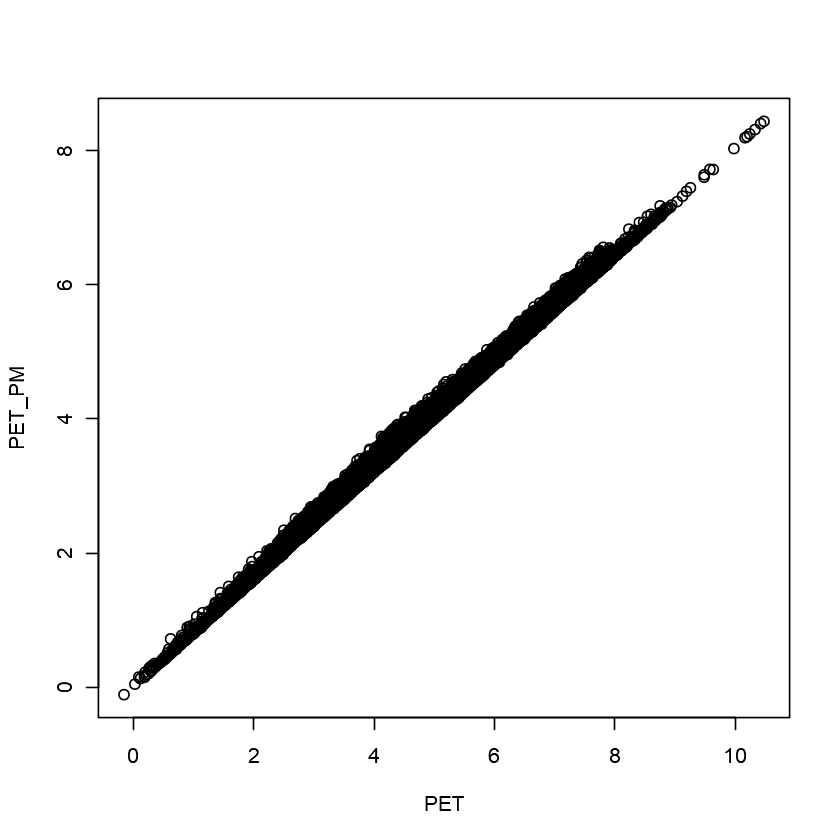

In [41]:
with(edata, plot(PET, PET_PM))
# PET is calculated with PT approach

## Calculate NEDI

### data prepare: Precip and PET agregate 30days sum

In [45]:
nsite = c('how', 'dap', 'das', 'dry', 'stp','asm')
edata$precip30d = NA
edata$PET30d    = NA
name_cols = c('site', 'date', 'precip', 'PET', 'precip30d', 'PET30d')

tmps = data.frame(matrix(NA, 1, length(name_cols) ))
colnames(tmps) = name_cols
for (i in unique(nsite))    
    {
     tmp = subset(edata, site== i , select = name_cols)

     for (iday in seq(30, length(tmp$date)))
         {
          tmp[iday,]$precip30d = sum(tmp[(iday-29):iday, ]$precip)
          tmp[iday,]$PET30d    = sum(tmp[(iday-29):iday, ]$PET_PM)
         }
     tmps = rbind(tmps, tmps = tmp) 
     }     

In [46]:
summary(tmps)

     site               date               precip             PET         
 Length:20625       Length:20625       Min.   :  0.000   Min.   :-0.1089  
 Class :character   Class :character   1st Qu.:  0.000   1st Qu.: 3.2018  
 Mode  :character   Mode  :character   Median :  0.000   Median : 3.9559  
                                       Mean   :  3.099   Mean   : 3.9951  
                                       3rd Qu.:  0.200   3rd Qu.: 4.8014  
                                       Max.   :194.564   Max.   : 8.4355  
                                       NA's   :1         NA's   :1        
   precip30d          PET30d   
 Min.   :  0.00   Min.   :0    
 1st Qu.:  0.00   1st Qu.:0    
 Median : 20.49   Median :0    
 Mean   : 93.00   Mean   :0    
 3rd Qu.:144.60   3rd Qu.:0    
 Max.   :776.00   Max.   :0    
 NA's   :175      NA's   :175  

In [47]:
# Get 30 days accumlated precip and PET
wdata = tmps[-1,] # remove the first NA row

### NEDIad30_lag30 Calculated W (water availability) with 30 days lagged

In [49]:
# case 30 days lag: NEDIad30_lag0
lag = 30 # days
wdata$Wad30_lag30    = NA
wdata$NEDIad30_lag30 = NA
name_cols = c('site', 'date', 'precip', 'PET', 'precip30d', 'PET30d', 'Wad30_lag30', 'NEDIad30_lag30')

tmps = data.frame(matrix(NA, 1, length(name_cols) ))
colnames(tmps) = name_cols
for (i in unique(nsite))    
    {
     tmp = subset(wdata, site== i , select = name_cols )

     for (iday in seq(lag+1, length(tmp$date)))
         {
          tmp[iday,]$Wad30_lag30 = tmp[iday-lag,]$precip30d - tmp[iday,]$PET30d
          
         }
     Wmax = max(abs(tmp$Wad30_lag30), na.rm = T) 
     tmp$NEDIad30_lag30 = tmp$Wad30_lag30/Wmax 
     tmps = rbind(tmps, tmps = tmp) 
     }     

In [50]:
wdata$Wad30_lag30     = tmps[-1,]$Wad30_lag30
wdata$NEDIad30_lag30  = tmps[-1,]$NEDIad30_lag30

### NEDIad30_lag0 Calculated W (water availability) with 0 days lagged

In [51]:
# case 0 days lag: Wad30_lag0
# Wad30_lag0 = precip30d - PET30d
wdata$Wad30_lag0 = wdata$precip30d - wdata$PET30d

In [52]:
# Wmax for lag = 0 days
wdata$Wmax_lag0 = NA
wdata[wdata$site == 'how', 'Wmax_lag0'] =  max(abs(wdata[wdata$site == 'how', 'Wad30_lag0']), na.rm=T)
wdata[wdata$site == 'dap', 'Wmax_lag0'] =  max(abs(wdata[wdata$site == 'dap', 'Wad30_lag0']), na.rm=T)
wdata[wdata$site == 'das', 'Wmax_lag0'] =  max(abs(wdata[wdata$site == 'das', 'Wad30_lag0']), na.rm=T)
wdata[wdata$site == 'dry', 'Wmax_lag0'] =  max(abs(wdata[wdata$site == 'dry', 'Wad30_lag0']), na.rm=T)
wdata[wdata$site == 'stp', 'Wmax_lag0'] =  max(abs(wdata[wdata$site == 'stp', 'Wad30_lag0']), na.rm=T)
wdata[wdata$site == 'asm', 'Wmax_lag0'] =  max(abs(wdata[wdata$site == 'asm', 'Wad30_lag0']), na.rm=T)

In [53]:
### Calculate NEDI
wdata$NEDIad30_lag0 = wdata$Wad30_lag0/wdata$Wmax_lag0

In [54]:
write.csv(wdata, file='data/NEDI_daily.csv', row.names=F)

In [55]:
edata = edata[edata$site!='ade' & edata$site!='tte',]

In [56]:
dim(edata)
dim(wdata)

[1] 20624    28

[1] 20624    11

In [57]:
# reorder data frame with colummes of site and date
edata.rd = edata[order(edata$site, as.Date(edata$date)),]

In [58]:
head(edata.rd)

site,date,fe,fe_qcflag,rg,fh,rn,fsd,swc,ta,...,lai_grass,ebr,fe_cor,fh_cor,et_ob_cor,PET,NEDI_lag0,NEDI_lag30,precip30d,PET30d
asm,2010-09-03,97.53923,1.0000000,16.20047,133.6796,232.0331,287.9045,0.24216297,20.27125,...,0.09629074,1.0712877,91.04858,124.7841,1.270964,2.113437,NA,NA,NA,NA
asm,2010-09-04,127.42732,0.2608696,38.28930,143.6944,405.9317,595.3478,0.21113582,17.92765,...,0.09781502,0.7374604,172.79209,194.8503,2.919834,4.194895,NA,NA,NA,NA
asm,2010-09-05,128.38460,0.0000000,41.40268,180.2400,409.2160,589.9947,0.15574198,17.87272,...,0.09930358,0.8390795,153.00647,214.8068,2.585497,4.191610,NA,NA,NA,NA
asm,2010-09-06,106.39071,0.0000000,42.98975,187.5803,398.4354,590.1765,0.12474011,17.76354,...,0.10075795,0.8270489,128.63896,226.8067,2.173736,4.098442,NA,NA,NA,NA
asm,2010-09-07,75.58277,0.3333333,47.63041,139.1003,341.3030,502.0445,0.10609103,20.44793,...,0.10217879,0.7310287,103.39234,190.2802,1.823081,3.723884,NA,NA,NA,NA
asm,2010-09-08,70.63693,0.7391304,65.54825,163.6179,383.3728,564.9573,0.09529417,25.98139,...,0.10356342,0.7370570,95.83646,221.9881,1.619441,4.173325,NA,NA,NA,NA


In [59]:
wdata.rd = wdata[order(wdata$site, as.Date(wdata$date)),]

In [60]:
head(wdata.rd)

,site,date,precip,PET,precip30d,PET30d,Wad30_lag30,NEDIad30_lag30,Wad30_lag0,Wmax_lag0,NEDIad30_lag0
tmps.1,asm,2010-09-03,19.2,2.113437,NA,NA,NA,NA,NA,469.7,NA
tmps.2,asm,2010-09-04,0.0,4.194895,NA,NA,NA,NA,NA,469.7,NA
tmps.3,asm,2010-09-05,0.0,4.191610,NA,NA,NA,NA,NA,469.7,NA
tmps.4,asm,2010-09-06,0.0,4.098442,NA,NA,NA,NA,NA,469.7,NA
tmps.5,asm,2010-09-07,0.0,3.723884,NA,NA,NA,NA,NA,469.7,NA
tmps.6,asm,2010-09-08,0.0,4.173325,NA,NA,NA,NA,NA,469.7,NA


In [61]:
edata.rd$NEDI_lag0 = wdata.rd$NEDIad30_lag0 
edata.rd$NEDI_lag30 = wdata.rd$NEDIad30_lag30 

In [62]:
summary(edata.rd)

  site              date             fe            fe_qcflag      
 asm:2616   2010-09-03:    6   Min.   : -6.812   Min.   :0.00000  
 dap:2078   2010-09-04:    6   1st Qu.: 54.860   1st Qu.:0.00000  
 das:3593   2010-09-05:    6   Median :116.878   Median :0.04545  
 dry:3215   2010-09-06:    6   Mean   :122.813   Mean   :0.24187  
 how:5811   2010-09-07:    6   3rd Qu.:181.502   3rd Qu.:0.30769  
 stp:3311   2010-09-08:    6   Max.   :385.323   Max.   :1.00000  
            (Other)   :20588                                      
       rg               fh               rn               fsd        
 Min.   :-38.22   Min.   :-41.13   Min.   : -8.607   Min.   : 35.36  
 1st Qu.: 24.79   1st Qu.: 74.53   1st Qu.:279.329   1st Qu.:463.14  
 Median : 37.45   Median :118.97   Median :324.618   Median :517.16  
 Mean   : 37.86   Mean   :122.60   Mean   :325.285   Mean   :504.50  
 3rd Qu.: 50.60   3rd Qu.:167.22   3rd Qu.:377.248   3rd Qu.:571.45  
 Max.   :123.27   Max.   :339.20   Max.   :5

In [68]:
write.csv(edata.rd[, -c(27,28)], file = 'data/allsite6_flux_NEDI.csv', row.names= F)